# 1D linearized shallow-water equation with wind stress


In [1]:
cd(@__DIR__)
using Pkg; Pkg.activate(".")
#Pkg.instantiate()  # Uncomment if needed for reproducibility
using JLD2, Plots, ComponentArrays, Statistics, Random, Measures

  Activating project at `~/Desktop/Deltares/Final Report Code/Model-2`


In [ ]:
const SEED = rand(UInt)
Random.seed!(SEED); println("Using seed = $SEED")

# Input data to show
show_init_state = "flat"         
show_wind_name = "periodic"   
show_longer = false 
folder = "data"

states = ["flat", "bump", "small_bump"] # all possible initial states
winds = ["periodic", "piecewise", "multi-frequency", "AR(2)"] # (or zero or constant) # all possible wind types

println("Initial state: $show_init_state, Wind: $show_wind_name, Longer: $show_longer")
nothing

Using seed = 12547863355696898658
Initial state: flat, Wind: periodic, Longer: false


### Setup

In [3]:
# Directory for report plots
if !isdir("report_plots")
    mkdir("report_plots")
end

# Load parameters function
function load_parameters(init_state, wind_name, hours)
    filename = show_longer ? "$(folder)/$(init_state)_$(wind_name)_longer_parameters.jld2" : "$(folder)/$(init_state)_$(wind_name)_parameters.jld2"
    
    if !isfile(filename)
        error("File not found: $filename")
    end

    @load filename params
    return params
end

nothing

In [4]:
const SEED = rand(UInt)
Random.seed!(SEED); println("Using seed = $SEED")

const DEBUG = true  # set to false to hide prints

# Utils debug print 
function debug(msg, override::Bool=DEBUG)
    if override
        println(msg)
    end
end

# Util constant function
function constant_func(t, value=0.0)
    return value
end

# Load model helpers
include("model_1d_surge_wave.jl")
include("wind_forcing_functions.jl") 
include("normalization-utils.jl")

# Define plot colors
colors = palette(:bluegreenyellow)[1:6]
cur_colors = theme_palette(:auto)

Using seed = 6459771864336450742


### Input Data Visualization

Plotting initial conditions comparison...


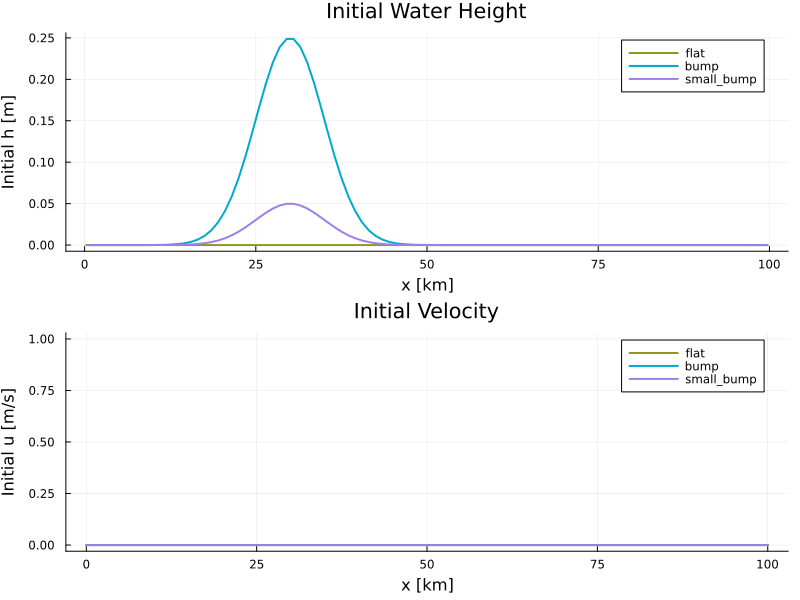

In [5]:
println("Plotting initial conditions comparison...")
fig = plot(layout=(2,1), size=(800, 600), title="Comparison of Initial Conditions")

# Load different initial states with same wind forcing
for (i, state) in enumerate(states)
    params = load_parameters(state, show_wind_name, show_longer)  # Use shorter simulation
    p1 = plot!(fig[1], 1e-3 .* params[:x_h], params[:x0].h, label=state, linewidth=2, color=cur_colors[i + 9], xlabel="x [km]", ylabel="Initial h [m]", title="Initial Water Height")
    p2 = plot!(fig[2], 1e-3 .* params[:x_u], params[:x0].u, label=state, linewidth=2, color=cur_colors[i + 9], xlabel="x [km]", ylabel="Initial u [m/s]", title="Initial Velocity")
end

savefig(fig, "report_plots/initial_conditions_comparison.png")
display(fig)

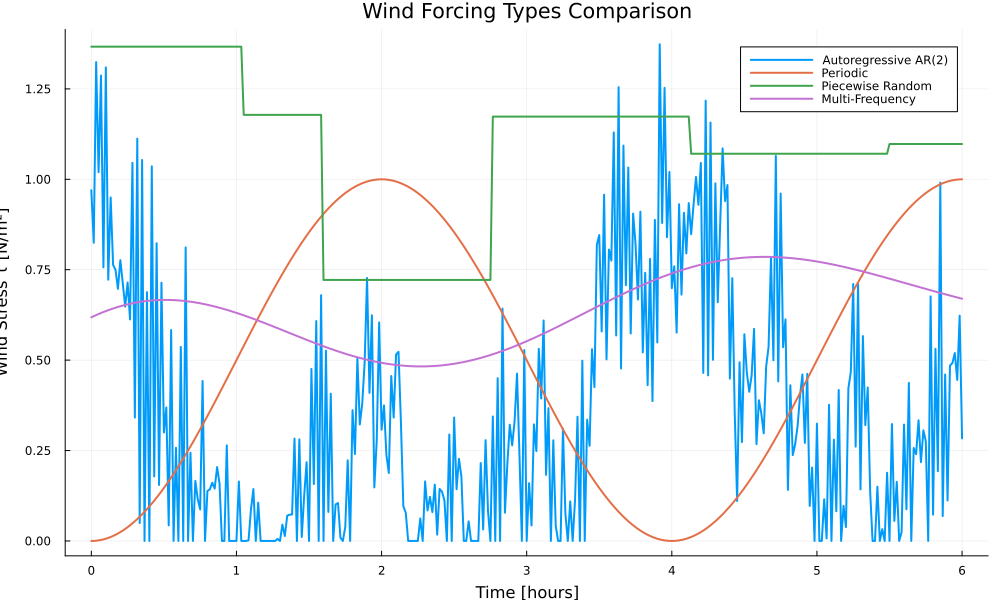

Plotting wind forcing comparison...


In [6]:
println("Plotting wind forcing comparison...")

# Use parameters from loaded data
params = load_parameters(show_init_state, show_wind_name, show_longer)
t_start = params[:t_start]
t_end = params[:t_end] 
dt_output = params[:dt_output]
times = params[:times]
amplitude = params[:amplitude]

# Different wind forcings
forcings = Dict(
    "Periodic" => make_tau_periodic(amplitude, params[:period]),
    "Multi-Frequency" => make_tau_multifreq(amplitude=amplitude, periods=params[:periods], weights=params[:weights], seed=params[:wind_seed]),
    "Piecewise Random" => make_tau_piecewise(amplitude=amplitude, avg_duration=params[:avg_duration], noise_level=params[:noise_level], seed=params[:wind_seed]),
    "Autoregressive AR(2)" => make_tau_ar(amplitude=amplitude, coeffs=params[:coeffs], sigma=params[:sigma], seed=params[:wind_seed]),
    #"Constant" => make_tau_constant(amplitude),
    #"Zero" => make_tau_zero()
)

fig = plot(size=(1000, 600), title="Wind Forcing Types Comparison")

# Plot each forcing
for (name, tau_func) in forcings
    tau_values = [tau_func(t) for t in times]
    plot!(times./3600, tau_values, label=name, linewidth=2)
end

xlabel!("Time [hours]"); ylabel!("Wind Stress τ [N/m²]")
savefig(fig, "report_plots/wind_forcing_comparison.png")
display(fig)

Plotting depth profile with stations...


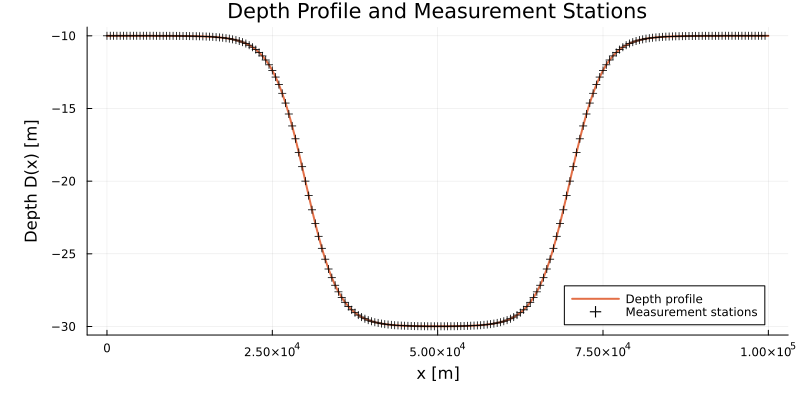

In [7]:
println("Plotting depth profile with stations...")

params = load_parameters("flat", "periodic", show_longer)
fig = plot(params[:grid_u], -params[:D], linewidth=2, label="Depth profile", xlabel="x [m]", ylabel="Depth D(x) [m]",
           title="Depth Profile and Measurement Stations", size=(800, 400), color=cur_colors[2], left_margin=8mm, bottom_margin=7mm)

# Mark station locations
scatter!(params[:grid_u][params[:station_idxs]], -params[:D][params[:station_idxs]], markersize=4, label="Measurement stations", color=:black, marker=:cross)

savefig(fig, "report_plots/depth_profile_stations.png")
display(fig)

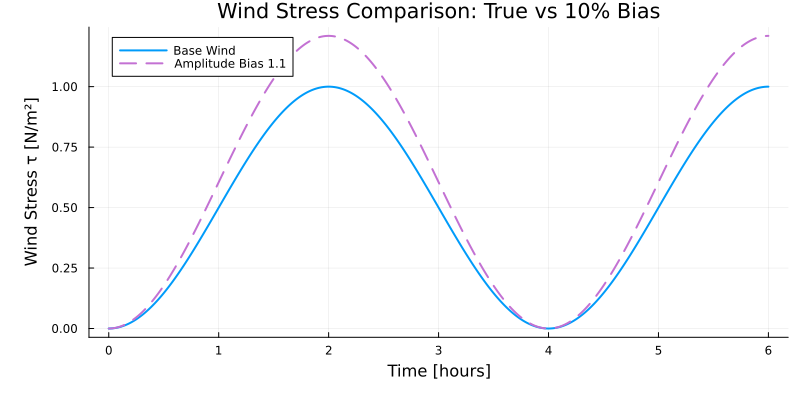

Plotting bias comparison...


In [8]:
println("Plotting bias comparison...")

# Use parameters from loaded data
params = load_parameters(show_init_state, show_wind_name, show_longer)
t_start = params[:t_start]
t_end = params[:t_end]
dt_output = params[:dt_output]
times = params[:times]

amplitude = params[:amplitude]
period = params[:period]
bias_factor = params[:bias_factor]

# Define nominal and biased wind stress functions
tau_nominal = make_tau_periodic(amplitude, period)
tau_true = make_tau_periodic(amplitude * bias_factor, period)

fig = plot(size=(800, 400), title="Wind Stress Comparison: True vs 10% Bias")

tau_nom_vals = [tau_nominal(t) for t in times]
tau_true_vals = [tau_true(t) for t in times]

plot!(times./3600, tau_nom_vals, label="Base Wind", linewidth=2, color=cur_colors[1], left_margin=8mm, bottom_margin=7mm)
plot!(times./3600, tau_true_vals, label="Amplitude Bias 1.1", linewidth=2, linestyle=:dash, color=cur_colors[4])

xlabel!("Time [hours]"); ylabel!("Wind Stress τ [N/m²]")
savefig(fig, "report_plots/wind_stress_bias_comparison.png")
display(fig)

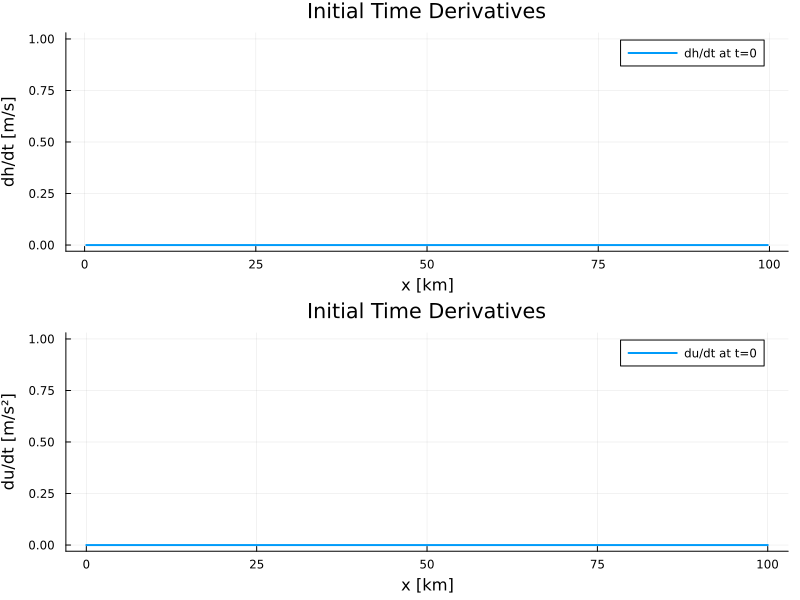

Plotting initial time derivatives...


In [9]:
println("Plotting initial time derivatives...")

# Recreate the model to compute derivatives
params = load_parameters("flat", "periodic", show_longer)
tau_nominal = make_tau_periodic(params[:amplitude], params[:period])
f_nominal = Wave1DSurge_cpu(params[:g], params[:D], params[:L], params[:W], params[:dx], params[:nx], 
                            params[:rho], params[:C], tau_nominal, (t) -> 0.0, (t) -> 0.0)

# Compute derivatives
dx_dt = similar(params[:x0])
f_nominal(dx_dt, params[:x0], f_nominal, 0.0)

fig = plot(layout=(2,1), size=(800, 600),  title="Initial Time Derivatives")

plot!(fig[1], 1e-3 .* params[:x_h], dx_dt.h, label="dh/dt at t=0", linewidth=2, xlabel="x [km]", ylabel="dh/dt [m/s]", color=cur_colors[1])
plot!(fig[2], 1e-3 .* params[:x_u], dx_dt.u, label="du/dt at t=0", linewidth=2, xlabel="x [km]", ylabel="du/dt [m/s²]", color=cur_colors[1])

savefig(fig, "report_plots/initial_time_derivatives.png")
display(fig)


In [10]:
function run_model_and_extract(f::Wave1DSurge_cpu, x0, times, station_idxs)
    # Set up and solve ODE problem
    prob = ODEProblem(f, x0, (times[1], times[end]))
    sol = solve(prob, KenCarp4(), saveat=times, reltol=1e-8, abstol=1e-10)

    # Extract results at station locations
    Y = zeros(length(times), length(station_idxs))
    for (i, t) in enumerate(times)
        Y[i, :] = sol(t).h[station_idxs]
    end
    return sol, Y
end


function print_parameter_summary()
    println("Generating parameter summary...")
    
    params = load_parameters(show_init_state, show_wind_name, show_longer)
    
    println("\n" * "="^50)
    println("SIMULATION PARAMETERS SUMMARY")
    println("="^50)
    println("Domain:")
    println("  Length (L): $(params[:L]/1000) km")
    println("  Grid points (nx): $(params[:nx])")
    println("  Spatial step (dx): $(round(params[:dx], digits=1)) m")
    
    println("\nPhysical parameters:")
    println("  Gravity (g): $(params[:g]) m/s²")
    println("  Water density (ρ): $(params[:rho]) kg/m³")
    println("  Chezy coefficient (C): $(params[:C])")
    println("  Channel width (W): $(params[:W]) m")
    
    println("\nDepth profile:")
    println("  Minimum depth: $(params[:D_min]) m")
    println("  Maximum depth: $(params[:D_max]) m")
    
    println("\nWind forcing:")
    println("  Type: $(params[:wind_name])")
    println("  Amplitude: $(params[:amplitude])")
    println("  Bias factor: $(params[:bias_factor])")
    
    println("\nSimulation:")
    println("  Initial state: $(params[:init_state])")
    println("  Duration: $(params[:hours]) hours")
    println("  Output interval: $(params[:dt_output]) s")
    println("  Number of stations: $(params[:n_stations])")
    
    println("="^50)
end

print_parameter_summary (generic function with 1 method)

In [11]:
println("Plotting multiple station responses...")

params = load_parameters(show_init_state, show_wind_name, show_longer)
for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end

q_left(t) = constant_func(t, 0.0)
q_right(t) = constant_func(t, 0.0)

# Generate 'true' data (observations from the true model)
debug("Running true model to generate observations...")
f_true = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_true, q_left, q_right)
sol_true, Y_true = run_model_and_extract(f_true, x0, times, station_idxs)

# Generate surrogate training data 
debug("Running nominal model to build surrogate training data...")
f_nominal = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_nominal, q_left, q_right)
sol_nominal, Y_nominal = run_model_and_extract(f_nominal, x0, times, station_idxs)

nothing

Plotting multiple station responses...
Running true model to generate observations...
Running nominal model to build surrogate training data...


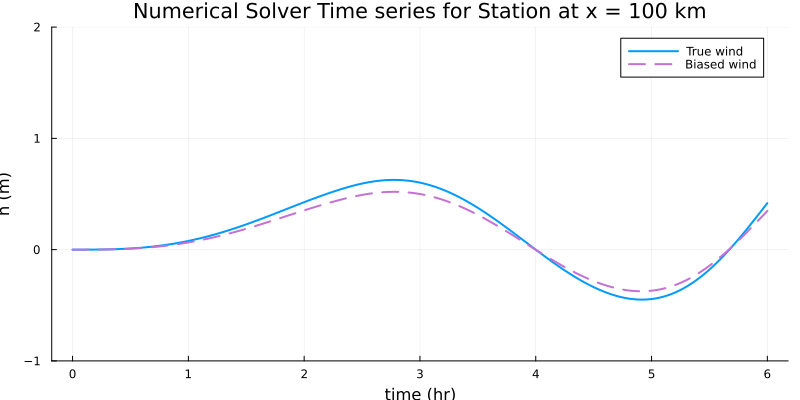

In [12]:
# Select representative stations
s = station_idxs[end]
p = plot(times./3600, Y_true[:, s], label="True wind", lw=2, ylim=(-1.0, 2.0), linewidth=2, color=cur_colors[1], size=(800, 400))
plot!(times./3600, Y_nominal[:, s], label="Biased wind", color=cur_colors[4], linestyle=:dash, linewidth=2)
xlabel!("time (hr)"); ylabel!("h (m)"); title!( "Numerical Solver Time series for Station at x = 100 km")
savefig(p, "report_plots/one_station_response.png")
display(p)

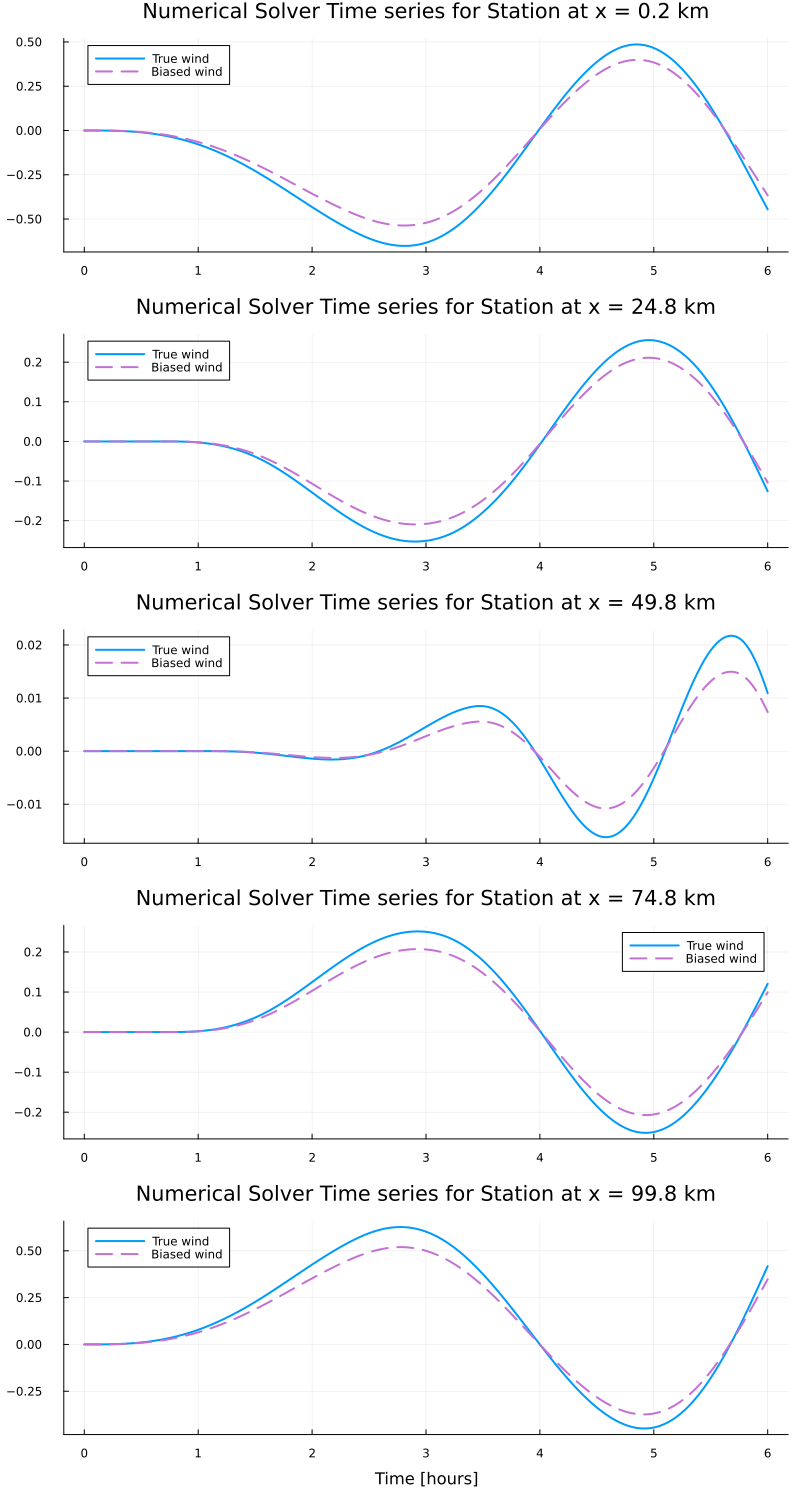

In [13]:
# Select representative stations
selected_stations = [1, n_stations÷4, n_stations÷2, 3*n_stations÷4, n_stations]

fig = plot(layout=(length(selected_stations),1), size=(800, 300*length(selected_stations)), title="Water Height at Different Stations: True vs Nominal")

for (i, station_idx) in enumerate(selected_stations)
    station_pos = params[:station_idxs][station_idx]
    x_pos = round(params[:grid_h][station_pos]/1000, digits=1)
    
    plot!(fig[i], times./3600, Y_true[:, station_idx], label="True wind", linewidth=2, color=cur_colors[1])
    plot!(fig[i], times./3600, Y_nominal[:, station_idx], label="Biased wind", linewidth=2, linestyle=:dash, color=cur_colors[4])
    
    ylabel!(fig[i], "h [m]"); title!(fig[i], "Numerical Solver Time series for Station at x = $(x_pos) km")
    
    if i == length(selected_stations)
        xlabel!(fig[i], "Time [hours]")
    end
end

savefig(fig, "report_plots/multiple_station_responses.png")
display(fig)